In [1]:
try:
    passes += 1
    !git pull
except:
    passes = 1
    !git clone https://github.com/arminwitte/FoolsUNet.git
    %cd FoolsUNet

Cloning into 'FoolsUNet'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 182 (delta 20), reused 6 (delta 4), pack-reused 155
Receiving objects: 100% (182/182), 52.43 MiB | 38.73 MiB/s, done.
Resolving deltas: 100% (101/101), done.
/kaggle/working/FoolsUNet


In [2]:
import tensorflow as tf

print(tf.__version__)

2024-05-26 23:28:13.326623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 23:28:13.326751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 23:28:13.603906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
import tensorflow_datasets as tfds

In [4]:
dataset, info = tfds.load("imagenet_resized/64x64:0.*.*", with_info=True, data_dir="/kaggle/tmp/")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1281167 [00:00<?, ? examples/s]

Shuffling /kaggle/tmp/imagenet_resized/64x64/0.1.0.incompleteAYGYRR/imagenet_resized-train.tfrecord*...:   0%|…

Generating validation examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /kaggle/tmp/imagenet_resized/64x64/0.1.0.incompleteAYGYRR/imagenet_resized-validation.tfrecord*...: …

Dataset imagenet_resized downloaded and prepared to /kaggle/tmp/imagenet_resized/64x64/0.1.0. Subsequent calls will reuse this data.


In [5]:
dataset

{Split('train'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [6]:
info

tfds.core.DatasetInfo(
    name='imagenet_resized',
    full_name='imagenet_resized/64x64/0.1.0',
    description="""
    This dataset consists of the ImageNet dataset resized to fixed size. The images
    here are the ones provided by Chrabaszcz et. al. using the box resize method.
    
    For [downsampled ImageNet](http://image-net.org/download.php) for unsupervised
    learning see `downsampled_imagenet`.
    
    those from the other ImageNet datasets provided by Tensorflow datasets. See the
    original
    [label list](https://github.com/PatrykChrabaszcz/Imagenet32_Scripts/blob/master/map_clsloc.txt),
    and the
    [labels used by this dataset](https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/imagenet_resized_labels.txt).
    Additionally, the original authors 1 index there labels which we convert to 0
    indexed by subtracting one.
    """,
    config_description="""
    Images resized to 64x64
    """,
    homepage='https://patrykc

In [7]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [8]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (64, 64))
    input_label = datapoint["label"]

    input_image = normalize(input_image)

    return input_image, input_label

In [9]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import layers
class Augment(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [12]:
train_batches = (
    train_images#.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

## Get pre-trained encoder and attach classification head

In [13]:
from foolsunet.model import foolsunet

In [14]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    base_model = tf.keras.models.load_model("foolsunet_imagenette.keras")
    #base_model = foolsunet()
    base_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_downsample (Sequential) │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_downsample (Sequential) │ (None, 64, 64, 128)    │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │       142,788 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       284,384 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       499,206 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_invres_downsample       │ (None, 4, 4, 192)      │     1,101,248 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 1024)     │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1024)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 1, 1, 10)       │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Flatten)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,901,862 (26.33 MB)

 Trainable params: 2,293,144 (8.75 MB)

 Non-trainable params: 22,428 (87.61 KB)

 Optimizer params: 4,586,290 (17.50 MB)

### Define encoder

In [15]:
# Use the activations of these layers
layer_names = [
    #'block_1_downsample',   # 128x128
    #'block_2_downsample',   # 64x64
    'block_3_invres_downsample',   # 32x32
    'block_4_invres_downsample',  # 16x16 
    'block_5_invres_downsample',      # 8x8
    'block_6_invres_downsample', # 4x4
]
base_model_layers = [base_model.get_layer(name) for name in layer_names]

# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

### Define classifier

In [16]:
def assemble_model():
    inputs = tf.keras.layers.Input(shape=[64, 64, 3])
    x = inputs
#     x = base_model.input
#     x = down_stack(inputs)
    x = tf.keras.layers.Conv2D(128,1,activation='relu')(x)
    for layer in base_model_layers:
#         layer.trainable = False
        x = layer(x)
    x = tf.keras.layers.Conv2D(1024, 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Activation("relu6")(x)
    x = tf.keras.layers.AveragePooling2D(4)(x)
    x = tf.keras.layers.Conv2D(num_classes, 1)(x)
    x = tf.keras.layers.Flatten(name="outputs")(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
num_classes = 1000
# classification_head = tf.keras.Sequential([
#     tf.keras.layers.Input([8,8,128]),
#     tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes, name="outputs"),])
# # classification_head.build()

In [18]:
# model = tf.keras.Sequential([base_model.get_layer(name) for name in layer_names] + [layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs"),
#                                                                                    ])
# model.build()

In [19]:
with mirrored_strategy.scope():
    model = assemble_model()
    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
    model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │       142,788 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       284,384 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       499,206 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_invres_downsample       │ (None, 4, 4, 192)      │     1,101,248 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 4, 4, 1024)     │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1024)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 1, 1, 1000)     │     1,025,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Flatten)               │ (None, 1000)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,254,866 (12.42 MB)

 Trainable params: 3,232,694 (12.33 MB)

 Non-trainable params: 22,172 (86.61 KB)

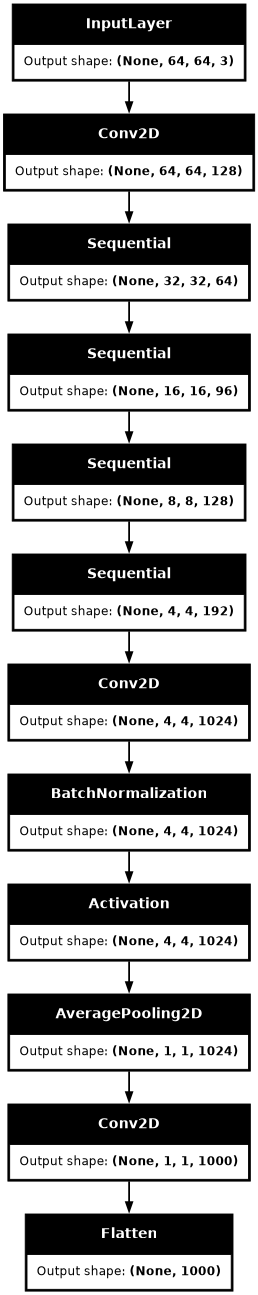

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [21]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["validation"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    # callbacks=[DisplayCallback()]
)

Epoch 1/5
20018/20018 ━━━━━━━━━━━━━━━━━━━━ 6828s 336ms/step - accuracy: 0.0041 - loss: 13.6370 - val_accuracy: 0.0068 - val_loss: 6.3754
Epoch 2/5
20018/20018 ━━━━━━━━━━━━━━━━━━━━ 6717s 336ms/step - accuracy: 0.0400 - loss: 11.8077 - val_accuracy: 0.0321 - val_loss: 5.6370
Epoch 3/5
20018/20018 ━━━━━━━━━━━━━━━━━━━━ 6732s 336ms/step - accuracy: 0.1171 - loss: 10.4242 - val_accuracy: 0.0611 - val_loss: 5.1797
Epoch 4/5
20018/20018 ━━━━━━━━━━━━━━━━━━━━ 6726s 336ms/step - accuracy: 0.1840 - loss: 9.6733 - val_accuracy: 0.0966 - val_loss: 4.7598
Epoch 5/5
20018/20018 ━━━━━━━━━━━━━━━━━━━━ 6729s 336ms/step - accuracy: 0.2381 - loss: 9.1663 - val_accuracy: 0.0950 - val_loss: 4.8842


In [22]:
# Save the entire model as a `.keras` zip archive.
model.save("foolsunet_imagenet_resized.keras")

In [23]:

model.save_weights("foolsunet_imagenet_resized.weights.h5")

In [24]:
new_model = tf.keras.models.load_model("foolsunet_imagenet_resized.keras")

# Show the model architecture
new_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │       142,788 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       284,384 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       499,206 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_invres_downsample       │ (None, 4, 4, 192)      │     1,101,248 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 4, 4, 1024)     │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1024)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 1, 1, 1000)     │     1,025,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Flatten)               │ (None, 1000)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,720,256 (37.08 MB)

 Trainable params: 3,232,694 (12.33 MB)

 Non-trainable params: 22,172 (86.61 KB)

 Optimizer params: 6,465,390 (24.66 MB)